In [29]:
from stpy.kernels import KernelFunction
from stpy.continuous_processes.nystrom_fea import NystromFeatures
from stpy.helpers.helper import interval_torch
import torch
from torch.nn import Sequential, Linear
import torch.optim as optim

In [30]:
# General convention
# x \in (n,d)
# y \in (n,1)

In [31]:
kernel = KernelFunction(kernel_name="matern", gamma=0.1, nu = 3.5, d = 1)

In [32]:
# custom kernel
kernel_fn = lambda x,y: torch.sum(x**2 + y**2).view(-1,1)
kernel_custom = KernelFunction(kernel_function=kernel_fn, d = 1)

In [33]:
x = interval_torch(10,1)
x

tensor([[-1.0000],
        [-0.7778],
        [-0.5556],
        [-0.3333],
        [-0.1111],
        [ 0.1111],
        [ 0.3333],
        [ 0.5556],
        [ 0.7778],
        [ 1.0000]], dtype=torch.float64)

In [34]:
# creation of embedding object with m basis functions
embedding = NystromFeatures(kernel, m=10, approx="svd")
embedding.fit_gp(x,None)

In [35]:
#phi = lambda x: embedding.embed(x)

In [36]:
class ShallowModel(Sequential):
    def __init__(self, input_dim, output_dim, embedding):
        super(ShallowModel, self).__init__()
        self.dense = Linear(embedding.get_m(), output_dim, bias=False).double()
        self.phi = lambda x: embedding.embed(x)

    def forward(self, input):
        return self.dense(self.phi(input))

model = ShallowModel(1,1, embedding)

In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.03)

x = interval_torch(10,1).double()
test_fn = lambda x: torch.sin(x*20)*x
y = test_fn(x)

def loss_fn(x,y,model):
    y_hat = model(x)
    # likelihood + prior
    return torch.mean((y_hat - y)**2) + 0.001*torch.sum(model.dense.weight**2)

for i in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(x,y,model)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.3178572619498807
1 0.29498066623284985
2 0.273729287457963
3 0.2542209072594029
4 0.23633418507278145
5 0.21986138195368593
6 0.20462635390841258
7 0.19049375602083685
8 0.17735815472545488
9 0.16512970896477053
10 0.15373703635821448
11 0.14311719093264177
12 0.1332023770959094
13 0.1239160912174664
14 0.11518262164581436
15 0.10694097385710125
16 0.09915000662082864
17 0.09178611503854561
18 0.08483928342725293
19 0.07831085932530854
20 0.07221056969537916
21 0.06654843964494814
22 0.06132463379643274
23 0.056523914672969654
24 0.05211802295784946
25 0.04807278672867555
26 0.04435382137933888
27 0.040928890500274054
28 0.03776909797440885
29 0.03485062368725708
30 0.03215563652640442
31 0.02967018001883881
32 0.027380114751967617
33 0.02526862231800562
34 0.023317106396407383
35 0.021507762033601094
36 0.019825078528990864
37 0.018255936892260363
38 0.016789765698442344
39 0.015419226113017222
40 0.014140158832202253
41 0.012950023304110894
42 0.011846076363648763
43 0.0108249141

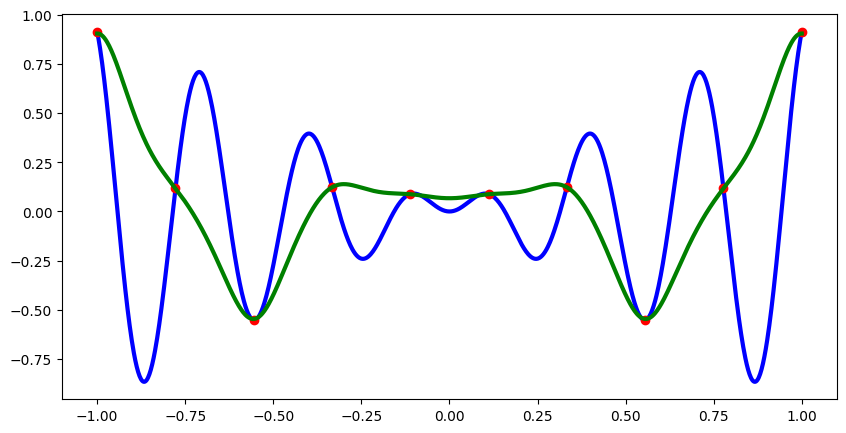

In [38]:
import matplotlib.pyplot as plt
x_fine = interval_torch(1000,1)
plt.figure(figsize=(10,5))
plt.plot(x_fine,test_fn(x_fine),'b-', lw = 3)
plt.plot(x, test_fn(x), 'ro', lw = 3)
plt.plot(x_fine, model(x_fine).detach().numpy(),'g-', lw = 3)

In [39]:
# model parameters
list(model.parameters())

[Parameter containing:
 tensor([[-3.3380e-16,  2.1585e-01, -1.0117e-15, -8.4905e-01,  3.7290e-18,
           1.2015e+00, -9.0436e-16,  3.1851e-01, -3.2458e-16,  8.3319e-02]],
        dtype=torch.float64, requires_grad=True)]

In [40]:
# optimization of hyperparameters

In [41]:
gamma = torch.tensor(0.1, requires_grad=True)